## GAN Basic Structure

In [1]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.7.6 (tags/v3.7.6:43364a7ae0, Dec 19 2019, 00:42:30) [MSC v.1916 64 bit (AMD64)]
1.4.0


In [2]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out
    

In [4]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [5]:
# A small batch of 3 samples, all zeros.
samples = torch.randn(5, 1, 28, 28) # batch size x channels x width x height
# This is how to do a forward pass (calls the .forward() function under the hood)
D(samples)

tensor([[0.5668],
        [0.6323],
        [0.5544],
        [0.6111],
        [0.5134]], grad_fn=<SigmoidBackward>)

In [6]:
for name, p in D.named_parameters():
    print(name, p.shape)

fc1.weight torch.Size([128, 784])
fc1.bias torch.Size([128])
fc2.weight torch.Size([1, 128])
fc2.bias torch.Size([1])


In [7]:
for name, p in G.named_parameters():
    print(name, p.shape)

fc1.weight torch.Size([128, 100])
fc1.bias torch.Size([128])
fc2.weight torch.Size([784, 128])
fc2.bias torch.Size([784])


In [8]:
# A small batch of 2 samples, random noise.
z = torch.randn(2, 100)
# This is how to do a forward pass (calls the .forward() function under the hood)
x_gen = G(z)
x_gen.shape

torch.Size([2, 1, 28, 28])

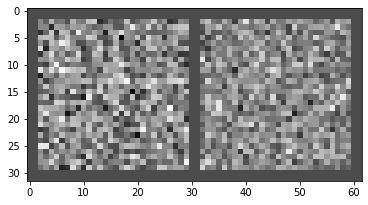

In [9]:
z = torch.randn(2, 100)
show_imgs(G(z))

## Loading the data and computing forward pass

In [16]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

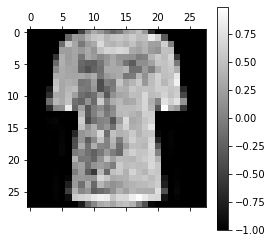

In [17]:
ix=149
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

Feed the image into the discriminator; the output will be the probability the (untrained) discriminator assigns to this sample being real.

In [18]:
# for one image:
Dscore = D(x)
Dscore

tensor([[0.5110]], grad_fn=<SigmoidBackward>)

In [19]:
# How you can get a batch of images from the dataloader:
xbatch, _ = iter(dataloader).next() # 64 x 1 x 28 x 28: minibatch of 64 samples
xbatch.shape
D(xbatch) # 64x1 tensor: 64 predictions of probability of input being real.
D(xbatch).shape

torch.Size([64, 1])

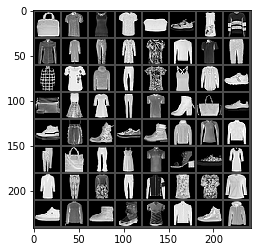

In [20]:
show_imgs(xbatch)

## The min-max game.

This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$



In [21]:
# Remember we have defined the discriminator and generator as:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [22]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

In [24]:
# STEP 1: Discriminator optimization step
x_real, _ = iter(dataloader).next()
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

print(D_x.mean().item(), D_G_z.mean().item())

0.58710116147995 0.5178802013397217


In [235]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real) # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.5688113570213318


## the full training loop

Device:  cpu
e0.i0/938 last mb D(x)=0.4696 D(G(z))=0.4948
e0.i100/938 last mb D(x)=0.9435 D(G(z))=0.3432
e0.i200/938 last mb D(x)=0.8057 D(G(z))=0.3395
e0.i300/938 last mb D(x)=0.8847 D(G(z))=0.1497
e0.i400/938 last mb D(x)=0.9430 D(G(z))=0.0401
e0.i500/938 last mb D(x)=0.8972 D(G(z))=0.1484
e0.i600/938 last mb D(x)=0.7526 D(G(z))=0.3655
e0.i700/938 last mb D(x)=0.8188 D(G(z))=0.2478
e0.i800/938 last mb D(x)=0.8800 D(G(z))=0.1964
e0.i900/938 last mb D(x)=0.9201 D(G(z))=0.0778
e1.i0/938 last mb D(x)=0.9413 D(G(z))=0.0483
e1.i100/938 last mb D(x)=0.8942 D(G(z))=0.0677
e1.i200/938 last mb D(x)=0.8633 D(G(z))=0.1554
e1.i300/938 last mb D(x)=0.6310 D(G(z))=0.3959
e1.i400/938 last mb D(x)=0.7450 D(G(z))=0.2683
e1.i500/938 last mb D(x)=0.9627 D(G(z))=0.0395
e1.i600/938 last mb D(x)=0.9298 D(G(z))=0.0898
e1.i700/938 last mb D(x)=0.8791 D(G(z))=0.1300
e1.i800/938 last mb D(x)=0.6167 D(G(z))=0.4280
e1.i900/938 last mb D(x)=0.5143 D(G(z))=0.4709
e2.i0/938 last mb D(x)=0.4819 D(G(z))=0.4008
e2.i10

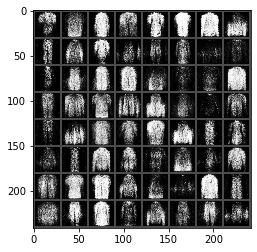

In [236]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

for epoch in range(3): # 10 epochs
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).next()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

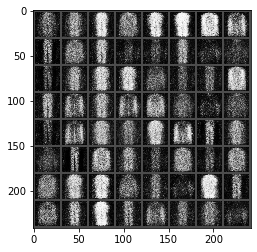

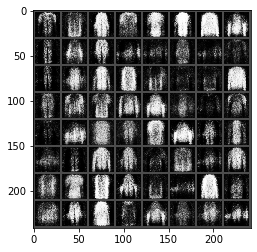

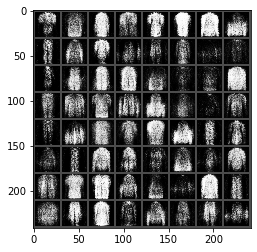

In [237]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

## DCGAN

In [1]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
%matplotlib inline

In [2]:
img_size = 64
batch_size=64
lr = 0.0002
beta1 = 0.5
niter= 25
outf= 'output'

dataset = datasets.CIFAR10( root = 'data',download=True,
                       transform=transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                         shuffle=True)

Files already downloaded and verified


In [3]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output


netG = _netG()
netG.apply(weights_init)
print(netG)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [6]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


netD = _netD()
netD.apply(weights_init)
print(netD)

_netD(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [7]:
criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [8]:
fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

In [11]:

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data.item(), errG.data.item(), D_x, D_G_z1, D_G_z2))
        if i % 5 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number